In [3]:
from core import TableDetector, TableRecognizer
from utils import pdf2images, resize_img, get_words_by_rect, extract_text_from_pdf, analyze_table_structure
from PIL import Image, ImageDraw
import utils
import tsr
import time
import matplotlib.pyplot as plt
import cv2
import fitz
import io
import camelot
import copy
import pickle
import pandas as pd
import importlib
import json
import os
from tqdm import tqdm

In [4]:
def find_table_info_by_page(tables, page_no):
    candidates = [tab for tab in tables if tab["page_no"] == page_no]
    candidates.sort(key=lambda x:x["score"], reverse=True)
    return candidates
        

def extract_table_img(img_list, page_no, bbox):
    img = img_list[page_no].copy()
    return img.crop(bbox)

def img_to_pdf_coordinate(table, recognition_res):
    xmin, ymin, _, _ = table["bbox"]
    for key in recognition_res.keys():
        for box in recognition_res[key]:
            box[0] = box[0] + xmin
            box[1] = box[1] + ymin
            box[2] = box[2] + xmin
            box[3] = box[3] + ymin


def get_intersection(col, row):
    return [col[0], row[1], col[2], row[3]]
    

def draw_table(pdf_imgs, page_no, bbox):
    img = pdf_imgs[page_no].copy()
    draw = ImageDraw.Draw(img)
    draw.rectangle(bbox, outline ="red")
    return img


def draw_bbox(img, bbox):
    draw = ImageDraw.Draw(img)
    draw.rectangle(bbox, outline ="red")


def draw_text(img, pos, text):
    draw = ImageDraw.Draw(img)
    draw.text(pos, text, fill="red")

    
def draw_bboxes(img, bbox_list):
    for bbox in bbox_list:
        draw_bbox(img, bbox)

def draw_all_tables(img_list, page_no, tables, box_type="enlarged_bbox"):
    img = img_list[page_no].copy()
    for tab in tables:
        if tab["page_no"] == page_no:
            bbox = tab[box_type]
            draw_bbox(img, bbox)
            pos = (bbox[2], bbox[1])
            draw_text(img, pos, f"{tab['score']:.3f}")
    return img

def load_table_json(fname):
    with open(fname) as f:
        return json.load(f)

def get_fnames(all_tables):
    fnames = set()
    for tab in all_tables:
        fnames.add(tab["fname"])
    return fnames

def get_tables_by_fname(all_tables, fname):
    return [tab for tab in all_tables if tab["fname"] == fname]

def get_tables_by_code(all_tables, code):
    res = []
    for tab in all_tables:
        if code == tab["fname"].split("/")[-1][:5]:
            res.append(tab)
    return res

def get_tables_by_page(tables, page_no):
    return [tab for tab in tables if tab["page_no"] == page_no]
    

In [5]:
from utils import table_detection, table_recogonition, extract_table_img
model_det = TableDetector(checkpoint_path="/home/liuqy/table_extraction/table-transformer/pubtables1m_detection_detr_r18.pth")
model_rec = TableRecognizer("/home/liuqy/table_extraction/table-transformer/pubtables1m_structure_detr_r18.pth")

----------------------------------------------------------------------------------------------------
loading model
loading model from checkpoint
----------------------------------------------------------------------------------------------------
loading model
loading model from checkpoint


In [15]:
import aspose.words as aw

path = "/home/liuqy/Desktop/New_TS_Data/"
output_path = "/home/liuqy/Desktop/New_TS_Data/found_tables/"

for fname in os.listdir(path):
    if fname[-4:] == ".pdf":
        print(fname)
        output_full_path = output_path + fname[:-4]
        if not os.path.exists(output_full_path):
            os.mkdir(output_full_path)

        full_path = path + fname
        tables, img_list, page_no_list = utils.table_detection(full_path, model_det, threshold=0.9)
        openned_pdf = fitz.open(full_path)
        
        for page_no in page_no_list:
            tabs_page_no = find_table_info_by_page(tables, page_no)
            if len(tabs_page_no) > 0:
                for tab in tabs_page_no:
                    _, cells, _ = tsr.table_to_cells(model_rec, openned_pdf, tab)
                    tsr.vis_cells(img_list[page_no], cells, copy=False)
                    draw_bbox(img_list[page_no], tab["enlarged_bbox"])
                    draw_text(img_list[page_no], [tab["enlarged_bbox"][2], tab["enlarged_bbox"][1]], f"{tab['score']:.5f}")
                img_list[page_no].save(output_full_path + f"/{page_no}.png")                


Building loan_(2) TS.pdf
Acquisition and share pledge_(1) FA.pdf
USD ARR lookback and stay rule_(6) TS annotated and modified.pdf
Acquisition and share pledge_(1) TS annotated.pdf
Acquisition and share pledge_(1) TS.pdf
Green loan KPI_(5) TS annotated.pdf
USD ARR lookback and stay rule_(6) TS_modified.pdf
Green loan_Dr_TS_clean.pdf
Aircraft_Shan_FA_modified.pdf
Green loan KPI and GBP SONIA_(4) FA.pdf
USD TERM_(3) TS.pdf
Building loan_K W Refinancing_TS_clean and modified.pdf
Green loan KPI_(5) FA.pdf
USD TERM_(3) FA_modified.pdf
Building loan_K W Refinancing_Facility Agreement and modified.pdf
Green loan KPI and GBP SONIA_(4) TS annotated.pdf
USD ARR lookback and stay rule_(6) FA_modified.pdf
Building loan_(2) TS annotated.pdf
Green loan KPI and GBP SONIA_(4) TS.pdf
Green loan_Dr_FA_modified.pdf
Building loan_(2) FA.pdf
USD TERM_(3) TS annotated.pdf
Aircraft_Shan_TS_clean and modified.pdf
Green loan KPI_(5) TS.pdf
Green loan_Dr_TS_Annotated.pdf
Building loan_K W Refinancing_TS_Annotate

In [26]:
"Building loan_(2) TS.pdf"[:-4]

'Building loan_(2) TS'

In [17]:
"Building loan_(2) TS    .pdf"[:-4]

'Building loan_(2) TS    '

In [86]:
path = "/home/liuqy/table_extraction/data/property_all_2021/"
debug_path = "/home/liuqy/table_extraction/debug_2021/"
all_tables = []
exception_files = []

code_list = []

with tqdm(total=len(os.listdir(path)), desc='Table Detection', leave=True, unit='Doc', unit_scale=True) as pbar:
    for fname in os.listdir(path):
        if fname[:5] == ".DS_S":
            pbar.update(1)
            continue
        if int(fname[:5]) in code_list:
            pdf = path + fname
            try:
                tables, _, _ = utils.table_detection(pdf, model_det, 0.5, 
                anchor_words=["2020", "2021"],
                caption_words=[],
                make_symmetric=False,
                debug=False,
                debug_output_path=debug_path+fname[:5])
                all_tables.extend(tables)
            except:
                print(fname)
                exception_files.append(fname)

        pbar.update(1)

Table Detection:  59%|█████▉    | 280/476 [32:04<12:56, 3.96s/Doc]   mupdf: cannot find ExtGState resource 'R2947'
mupdf: cannot find ExtGState resource 'R2953'
mupdf: cannot find ExtGState resource 'R3257'
mupdf: cannot find ExtGState resource 'R3435'
mupdf: cannot find ExtGState resource 'R3484'
mupdf: cannot find ExtGState resource 'R3562'
mupdf: cannot find ExtGState resource 'R4506'
mupdf: cannot find ExtGState resource 'R4881'
mupdf: cannot find ExtGState resource 'R5047'
mupdf: cannot find ExtGState resource 'R5339'
mupdf: cannot find ExtGState resource 'R3257'
mupdf: cannot find ExtGState resource 'R3257'
mupdf: cannot find ExtGState resource 'R3562'
mupdf: cannot find ExtGState resource 'R3562'
mupdf: cannot find ExtGState resource 'R4881'
mupdf: cannot find ExtGState resource 'R4881'
mupdf: cannot find ExtGState resource 'R4881'
mupdf: cannot find ExtGState resource 'R4881'
mupdf: cannot find ExtGState resource 'R5047'
mupdf: cannot find ExtGState resource 'R5047'
mupdf: cann

In [87]:
import json
with open("/home/liuqy/table_extraction/tables_property_all_2021_0221.json", "w") as f:
    json.dump(all_tables, f, indent=4)

In [88]:
len(all_tables)

20239

In [57]:
all_tables = load_table_json("/home/liuqy/table_extraction/tables_property_all_2021_0210.json")
fnames = get_fnames(all_tables)

190

In [25]:
all_tables = load_table_json("/home/liuqy/table_extraction/tables_property_all_2021_0210.json")
fnames = get_fnames(all_tables)

with tqdm(total=len(fnames), desc='TSR', leave=True, unit='Doc', unit_scale=True) as pbar:
    for fname in fnames:
        try:
            opened_pdf = fitz.open(fname)
            img_list, _ = utils.pdf2images_all(fname)
            tabs_by_fname = get_tables_by_fname(all_tables, fname)
            code = fname.split("/")[-1][:5]
            save_path = f"{debug_path}{code}/"
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            else:
                os.system(f"rm {save_path}*")
            
            for tab in tabs_by_fname:
                _, cells, _ = tsr.table_to_cells(model_rec, opened_pdf, tab)
                img = img_list[tab["page_no"]]
                vis_img = tsr.vis_cells(img, cells, copy=False)
                bbox = tab["enlarged_bbox"]
                draw_bbox(vis_img, bbox)
                draw_text(vis_img, [bbox[2], bbox[1]], str(tab["score"]))
                vis_img.save(f"{save_path}{tab['page_no']}.png")
        except:
            None
        pbar.update(1)

TSR: 100%|██████████| 5.00/5.00 [01:55<00:00, 23.1s/Doc]


In [14]:
importlib.reload(utils)


pdf = "/home/liuqy/table_extraction/data/property_eng_sample_2021/"
pdf += "09979_GREENTOWN MGMT_2021 Environmental, Social and Governance Report.pdf"
# pdf = "/home/liuqy/table_extraction/环球大通_00905_Environmental,SocialandGovernanceReport2021.pdf"
opened_pdf = fitz.open(pdf)
tables, _, page_no_list = utils.table_detection(pdf, model_det, 0.5, 
    # keywords=["emission", "scope", "energy", "ghg", "employee"],
    # anchor_words=["2020", "2021"],
    caption_words=[],
    make_symmetric=False,
    debug=False
)
img_list, _ = utils.pdf2images_all(pdf)

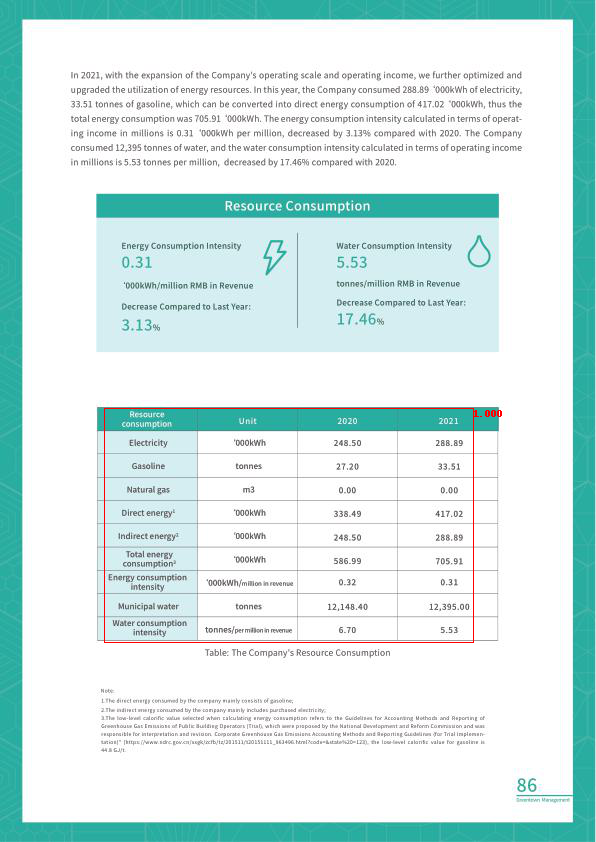

In [15]:
draw_all_tables(img_list, 87, tables)


In [18]:
tab

{'fname': '/home/liuqy/table_extraction/data/property_eng_sample_2021/09979_GREENTOWN MGMT_2021 Environmental, Social and Governance Report.pdf',
 'page_no': 87,
 'score': 0.9996621608734131,
 'bbox': [105.8928701210022,
  410.6151237487793,
  474.6941848754883,
  642.7330303955079],
 'raw_bbox': [105.36139678955078,
  394.88372802734375,
  446.2652587890625,
  605.922119140625],
 'enlarged_bbox': [104.1083984375,
  408.3092346191406,
  473.4687194824219,
  642.300537109375],
 'table_areas': '104.1083984375,433.6907653808594,473.4687194824219,199.699462890625'}

{'fname': '/home/liuqy/table_extraction/data/property_eng_sample_2021/09979_GREENTOWN MGMT_2021 Environmental, Social and Governance Report.pdf',
 'page_no': 87,
 'score': 0.9996621608734131,
 'bbox': [105.8928701210022,
  410.6151237487793,
  474.6941848754883,
  642.7330303955079],
 'raw_bbox': [105.36139678955078,
  394.88372802734375,
  446.2652587890625,
  605.922119140625],
 'enlarged_bbox': [104.1083984375,
  408.3092346191406,
  473.4687194824219,
  642.300537109375],
 'table_areas': '104.1083984375,433.6907653808594,473.4687194824219,199.699462890625'}

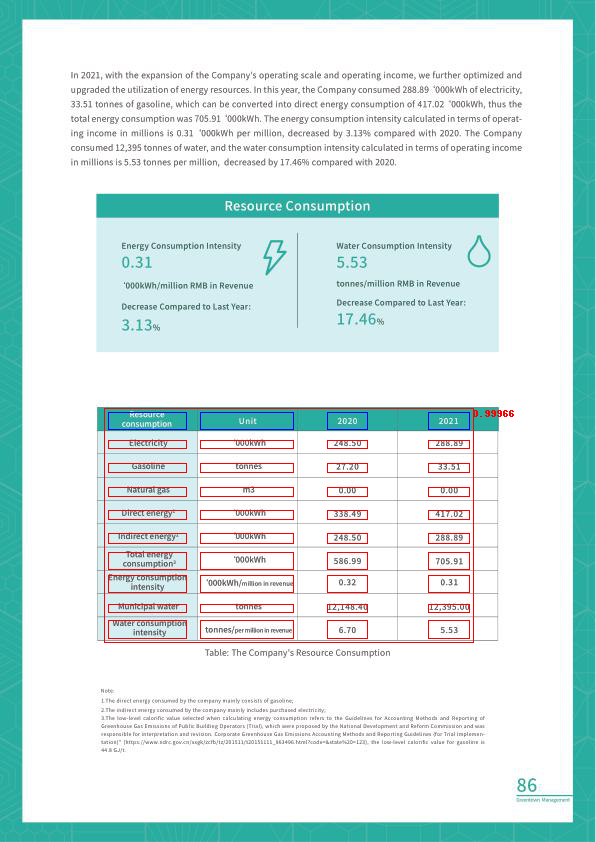

In [21]:
import tsr
importlib.reload(tsr)
page_no = 87
tab = find_table_info_by_page(tables, page_no)[0]

_, cells, _ = tsr.table_to_cells(model_rec, opened_pdf, tab)

vis = tsr.vis_cells(img_list[page_no], cells, copy=True)
# draw_bbox(vis, [
#             58.236541748046875,
#             132.68202209472656,
#             410.2611999511719,
#             536.1812133789062
#         ])
draw_bbox(vis, tab["enlarged_bbox"])
draw_text(vis, [tab["enlarged_bbox"][2], tab["enlarged_bbox"][1]], f"{tab['score']:.5f}")

vis

In [22]:
tsr.cells_to_df(cells)

,Resource consumption,Unit,2020,2021
0,Electricity,‘000kWh,248.50,288.89
1,Gasoline,tonnes,27.20,33.51
2,Natural gas,m3,0.00,0.00
3,Direct energy<s>1</s>,‘000kWh,338.49,417.02
4,Indirect energy<s>2</s>,‘000kWh,248.50,288.89
5,Total energy consumption<s>3</s>,‘000kWh,586.99,705.91
6,Energy consumption intensity,‘000kWh/million in revenue,0.32,0.31
7,Municipal water,tonnes,"12,148.40","12,395.00"
8,Water consumption intensity,tonnes/per million in revenue,6.70,5.53


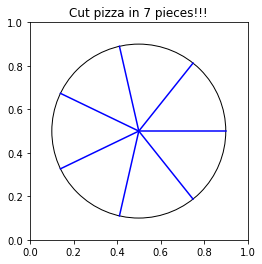

In [54]:
def cut_pizza(cut: int):
    figure, axes = plt.subplots()
    Drawing_colored_circle = plt.Circle(( 0.5 , 0.5 ), 0.4, fill=False)
    axes.set_aspect( 1 )
    axes.add_artist( Drawing_colored_circle )
    r = 2*np.pi / cut
    for i in range(cut):
        plt.plot((0.5, 0.5 + 0.4 * np.cos(i*r)), (0.5, 0.5 + 0.4 * np.sin(i*r)), "b")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(f"Cut pizza in {cut} pieces!!!")
    plt.show()

cut_pizza(7)

In [8]:
importlib.reload(tsr)

tsr.get_page_superscript_tokens(opened_pdf, page_no)[10]
# ttt = [t for t in tsr.get_page_tokens_without_superscript(opened_pdf, 76) 
#     if fitz.Rect(t["bbox"]).intersects([94.84396362304688, 95.63442993164062, 503.7812194824219, 140.63442993164062])]
# # "".join([t["text"] for t in ttt])
# ttt

{'text': '2',
 'bbox': (186.70230102539062,
  286.30499267578125,
  189.78170776367188,
  291.843505859375),
 'flags': 0,
 'block_num': 38,
 'line_num': 0,
 'span_num': 3}

In [12]:
importlib.reload(tsr)
tsr.get_page_tokens(opened_pdf, page_no)
tsr.cells_to_df(cells)


,Social KPIs,Group 2021,Group 2020,Headquarters 2021,Headquarters 2020,Construction 2021,2020,Property Management 2021,Property Management 2020,Other Subsidiaries in Hong Kong 2021,Other Subsidiaries in Hong Kong 2020,Other Subsidiaries in Mainland China 2021,Other Subsidiaries in Mainland China 2020
0,"*Employees by contract type, gender, age and e...","10,291","10,190","1,435","1,437",451,505,"3,239","3,436","3,934","3,752","1,232","1,060"
1,*By employment contract type*Full-time,"8,921","9,065","1,432","1,434",451,505,"3,045","3,222","2,761","2,844","1,232","1,060"
2,*By employment contract type*Part-time,"1,370","1,125",3,3,0,0,194,214,"1,173",908,0,0
3,*By gender*Male,"5,458","5,667",739,747,370,409,"2,011","2,275","1,626","1,619",712,617
4,*By gender*Female,"4,833","4,523",696,690,81,96,"1,228","1,161","2,308","2,133",520,443
5,*By gender*By age group,,,,,,,,,,,,
6,*By gender*Aged below 30,"1,079","1,278",175,185,46,52,397,456,350,492,111,93
7,*By gender*Aged 30-50,"4,510","4,516",809,830,138,177,"1,015","1,118","1,607","1,594",941,797
8,*By gender*Aged over 50,"4,702","4,396",451,422,267,276,"1,827","1,862","1,977","1,666",180,170
9,*By employee category*Managerial,822,751,406,402,6,5,145,146,176,154,89,44


In [27]:
importlib.reload(tsr)
# tsr.get_page_tokens_without_superscript(opened_pdf, page_no)
tsr.get_page_tokens(opened_pdf, page_no)[58]

{'text': 'type,',
 'bbox': (756.9507446289062,
  215.79054260253906,
  778.8956909179688,
  225.29054260253906),
 'flags': 0,
 'block_num': 5,
 'line_num': 0,
 'span_num': 3}

In [339]:
tsr.get_page_tokens_without_superscript(opened_pdf, page_no)

[{'text': '8',
  'bbox': (245.29449462890625,
   159.20823669433594,
   247.9200897216797,
   164.18597412109375),
  'flags': 0,
  'block_num': 4,
  'line_num': 2,
  'span_num': 1},
 {'text': '9',
  'bbox': (245.29449462890625,
   193.70823669433594,
   247.9200897216797,
   198.68597412109375),
  'flags': 0,
  'block_num': 5,
  'line_num': 1,
  'span_num': 1},
 {'text': '3 ',
  'bbox': (247.6920928955078,
   228.20823669433594,
   251.6304931640625,
   233.18597412109375),
  'flags': 0,
  'block_num': 6,
  'line_num': 1,
  'span_num': 1},
 {'text': '10',
  'bbox': (251.6304931640625,
   228.20823669433594,
   256.8816833496094,
   233.18597412109375),
  'flags': 0,
  'block_num': 6,
  'line_num': 1,
  'span_num': 2},
 {'text': '3',
  'bbox': (247.6920928955078,
   239.70823669433594,
   250.31768798828125,
   244.68597412109375),
  'flags': 0,
  'block_num': 6,
  'line_num': 7,
  'span_num': 1},
 {'text': '11',
  'bbox': (259.2427062988281,
   262.7082214355469,
   264.4939270019531,


In [60]:
dec = json.JSONDecoder()
dec.decode('{"Group Local": 410, "Group Non-local": 28, "Hong Kong Local": 180, "Hong Kong Non-local": 21, "Japan Local": 40, "Japan Non-local": 0, "Indonesia Local": 55, "Indonesia Non-local": 1, "Thailand Local": 135, "Thailand Non-local": 6, "Other locations Local": 0, "Other locations Non-local": 0}')

{'Group Local': 410,
 'Group Non-local': 28,
 'Hong Kong Local': 180,
 'Hong Kong Non-local': 21,
 'Japan Local': 40,
 'Japan Non-local': 0,
 'Indonesia Local': 55,
 'Indonesia Non-local': 1,
 'Thailand Local': 135,
 'Thailand Non-local': 6,
 'Other locations Local': 0,
 'Other locations Non-local': 0}

In [4]:
import debug_utils 


tsr_json = "/home/liuqy/table_extraction/tables_property_2021.json"
with open(tsr_json, "r") as f:
    tab_metrics = json.load(f)

metric_df = debug_utils.metric_to_df(tab_metrics)
metric_df.to_excel("metrics_2021.xlsx", index=False, engine='xlsxwriter')


In [24]:
importlib.reload(debug_utils)
code_list = debug_utils.gen_random_evaluation_set(10)
debug_utils.collect_debug_figures(code_list, "./c.tar.gz")

In [56]:
import re

def is_eng_doc(pdf):
    doc = fitz.open(pdf)
    
    cnt = 0
    for i in range(doc.pageCount):
        raw_words = [w[4] for w in utils.extract_text_from_pdf(doc, i)]
        join = " ".join(raw_words)
        search = re.findall(r'[\u4e00-\u9fff]+', join)
        cnt += len(search)
    
    if cnt <= 50:
        return True

path = "/home/liuqy/table_extraction/data/property_all_2020/"
res = []
with tqdm(total=len(os.listdir(path)), desc='Table Detection', leave=True, unit='Doc', unit_scale=True) as pbar:
    for f in os.listdir(path):
        pdf = path + f
        try:
            if is_eng_doc(pdf):
                res.append(pdf.split("/")[-1][:5])
        except:
            print(pdf)
        pbar.update(1)
    

Table Detection:   7%|▋         | 33.0/456 [00:09<01:30, 4.68Doc/s]mupdf: cannot recognize version marker
mupdf: no objects found


/home/liuqy/table_extraction/data/property_all_2020/.DS_Store


Table Detection:  17%|█▋        | 78.0/456 [00:21<01:02, 6.01Doc/s]mupdf: invalid page object
Table Detection: 100%|██████████| 456/456 [01:57<00:00, 3.87Doc/s] 


In [57]:
pd.DataFrame(data={"code": res}).to_excel("property_eng_2020.xlsx", index=False, engine='xlsxwriter')

In [58]:
len(res)

212